In [1]:
# HCASE Experiments KNN in HCASE Space
#
# Author: Gergely Zahoranszky-Kohalmi, PhD
#
# Email: gergely.zahoranszky-kohalmi@nih.gov
#
# Organization: National Center for Advancing Translational Sciences (NCATS/NIH)
#


In [2]:
import pandas as pd

import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem


import knn
from knn import get_mol, get_fingerprint, get_Tanimoto, compute_sim



In [3]:
# Configuration

fname_drug_emb_hcase_chembl = '../data/drugs_emb_hcase_chembl.tab'



fname_out_knn_drugs_emb_hcase_chembl = '../plots/knn/knn_5_app_drugs_drugbank_chembl_24_1_bms_dim_2.png'




fname_out_rnd_5_drugs_and_knns = '../data/rnd_5_app_drugs_drugbank_knn_5.tab'

fname_out_knn_drugs_emb_hcase_chembl_coordinates = '../data/knn_coords_app_drugs_drugbank_chembl_24_1_bms.tab'


fname_out_drugs_not_nn_5 = '../data/app_drugs_drugbank_all_not_nn_5.tab'
fname_out_drugs_not_nn_5_sim = '../data/similarity_app_drugs_drugbank_all_not_nn_5.tab'




fname_out_not_nn_drugs_emb_hcase_chembl = '../plots/knn/not_nn_app_drugbank_chembl_24_1_bms_dim_2.png'




max_nn = 5
fp_radius = 3
fp_length = 2048


num_rnd_selected_chemotypes = 5
num_not_nn_rnd_molecules = 25

random_seed = 55555
random_seed_not_nn = 11111


In [4]:
# Import datasets


# It's sufficient to perform this step once, from any of the datasets created at the space-embedding step,
# as the structural information is constant, and the structures with nonsense/empty 
# Bemis-Murcko scaffodls were already eliminated.

df_emb = pd.read_csv (fname_drug_emb_hcase_chembl, sep = '\t')

#print (df_emb.shape[0])

In [5]:
# Clean-up datasets

df_2 = df_emb[df_emb['hc_order'] == 2].copy()
df_3 = df_emb[df_emb['hc_order'] == 3].copy()
df_4 = df_emb[df_emb['hc_order'] == 4].copy()
df_5 = df_emb[df_emb['hc_order'] == 5].copy()
df_6 = df_emb[df_emb['hc_order'] == 6].copy()
df_7 = df_emb[df_emb['hc_order'] == 7].copy()
df_8 = df_emb[df_emb['hc_order'] == 8].copy()

# It's sufficient to work only with the embedding results of highest z = 8, as it includes all the Drug molecules
# Using all the ebeddings at other z values would lead to redundancy artifact and would invalidate the workflow
# logic.
df_valid = knn.filter_valid_mols (df_8, 'structure')


In [6]:
# Functions

data_labels_knn = {}

data_labels_knn['DB04931'] = 'A'
data_labels_knn['DB01284'] = 'B'
data_labels_knn['DB00050'] = 'C'
data_labels_knn['DB09067'] = 'D'
data_labels_knn['DB06825'] = 'E'
data_labels_knn['DB01174'] = 'F'
data_labels_knn['DB00794'] = 'G'
data_labels_knn['DB05246'] = 'H'
data_labels_knn['DB01437'] = 'I'
data_labels_knn['DB00252'] = 'J'
data_labels_knn['DB01357'] = 'K'
data_labels_knn['DB04575'] = 'L'
data_labels_knn['DB00655'] = 'M'
data_labels_knn['DB00783'] = 'N'
data_labels_knn['DB04573'] = 'O'
data_labels_knn['DB01249'] = 'P'
data_labels_knn['DB09135'] = 'Q'
data_labels_knn['DB09134'] = 'R'
data_labels_knn['DB09313'] = 'S'
data_labels_knn['DB01578'] = 'T'
data_labels_knn['DB11609'] = 'U'
data_labels_knn['DB00257'] = 'V'
data_labels_knn['DB00333'] = 'W'
data_labels_knn['DB01231'] = 'X'
data_labels_knn['DB08944'] = 'Y'


data_labels_rnd = {}

data_labels_rnd['DB11994'] = 'A'
data_labels_rnd['DB00593'] = 'B'
data_labels_rnd['DB00613'] = 'C'
data_labels_rnd['DB00172'] = 'D'
data_labels_rnd['DB00704'] = 'E'
data_labels_rnd['DB00204'] = 'F'
data_labels_rnd['DB01104'] = 'G'
data_labels_rnd['DB01114'] = 'H'
data_labels_rnd['DB00860'] = 'I'
data_labels_rnd['DB00770'] = 'J'
data_labels_rnd['DB08924'] = 'K'
data_labels_rnd['DB06282'] = 'L'
data_labels_rnd['DB06736'] = 'M'
data_labels_rnd['DB11184'] = 'N'
data_labels_rnd['DB00496'] = 'O'
data_labels_rnd['DB08877'] = 'P'
data_labels_rnd['DB00947'] = 'Q'
data_labels_rnd['DB08943'] = 'R'
data_labels_rnd['DB01599'] = 'S'
data_labels_rnd['DB02546'] = 'T'
data_labels_rnd['DB01138'] = 'U'
data_labels_rnd['DB00237'] = 'V'
data_labels_rnd['DB01325'] = 'W'
data_labels_rnd['DB01124'] = 'X'
data_labels_rnd['DB00177'] = 'Y'

colors = {}

colors['DB00006'] = 'green'
colors['DB00849'] = 'orange'
colors['DB00977'] = 'purple'
colors['DB01362'] = 'aqua'
colors['DB04837'] = 'blue'





def get_color (id, df_knn):
    # This only works if Test 1 and Test 2 below are OK.
    c = 0
    if id in list(df_knn['id']):
        x = df_knn[df_knn['id'] == id]
        c = list(x['knn_color'])[0]
    else:
        c = 0
   
    return (c)

 
def get_knn_type (id, df_knn):
    t = 'other'
    parents = df_knn[df_knn['knn_type'] == 'parent']
    parent_ids = list(parents['id'])
    nns = df_knn[df_knn['knn_type'] == 'nn']
    nn_ids = list(nns['id'])


    if id in parent_ids:
        t = 'parent'
    elif id in nn_ids:
        t = 'nn'
    else:
        t = 'other'
   
    return (t) 

    
def color_knns (df, df_knn):
    df['knn_color'] = df.apply (lambda x: get_color (x['id'], df_knn), axis = 1)
    df['knn_type'] = df.apply (lambda x: get_knn_type (x['id'], df_knn), axis = 1)



    return (df)


def check_rnd_knn (df):
    check = True
    #df = pd.read_csv ('../../data/rnd_5_app_drugs_drugbank_knn_5.tab', sep = '\t')

    query_ids = {}
    target_ids = {}


    for id in list(df['knn_query_id']):
        query_ids[id] = True

    query_ids = list(query_ids.keys())

    if len(query_ids) != num_rnd_selected_chemotypes:
        check = False

    for id in query_ids:
        if id in list(df['knn_target_id']):
            check = False


    for id in list(df['knn_target_id']):
        if id not in list(target_ids.keys()):
            target_ids[id] = True
        else:
            check = False

    return (check)

"""
def save_mol_depiction (smiles, id, dataset_name, path):
    DrawingOptions.atomLabelFontSize = 55
    DrawingOptions.dotsPerAngstrom = 100
    DrawingOptions.bondLineWidth = 3.0
    mol = Chem.MolFromSmiles(smiles)
    fname = path + dataset_name + '_' + id + '.png'
    Chem.Draw.MolToFile(mol, fname, size=(1000, 1000))
"""

def get_letter (data_labels, id):
    return(data_labels[id])

def assign_data_labels (df, data_labels):
    df['data_label'] = df.apply(lambda x: get_letter(data_labels, x['knn_target_id']), axis = 1)
    
    return (df)
    

def separate_query_from_target_mols (df_knn):
    df_target = df_knn[['knn_target_id', 'knn_target_structure', 'knn_color', 'data_label']].copy()
    df_target['knn_type'] = 'nn'
    df_target = df_target.rename(columns = {
        'knn_target_id': 'id',
        'knn_target_structure': 'smiles'
    #    'knn_color': 'color'
    })

    df_query = df_knn[['knn_query_id', 'knn_query_structure', 'knn_color', 'data_label']].copy()
    df_query['knn_type'] = 'parent'
    df_query = df_query.rename(columns = {
        'knn_query_id': 'id',
        'knn_query_structure': 'smiles'
    #    'knn_color': 'color'
    })

    df_query = df_query.groupby(['id'], as_index = False).agg({
        'smiles': 'first',
         'knn_color': 'first',
         'knn_type': 'first',
         'data_label': 'first'
    })

    df_query = df_query.reset_index(drop = True)

    df_knn = df_query.append(df_target, ignore_index = True)

    return (df_knn)



    
def panel_plot_multi (subfig, df, df_knn, subfig_label):
    #df = df [df[df['hc_order'] == hc_order]
    df_other = df[df['knn_type'] == 'other']
    
    
    df_1 = df[df['knn_color'] == 1]
    df_1_parent = df_1[df_1['knn_type'] == 'parent']
    df_1_nn = df_1[df_1['knn_type'] == 'nn']

    #print (df.head)
    #print (df_knn.head)
    
    df_1_nn = df_1_nn.drop(columns = ['knn_color'])
    df_1_nn = df_1_nn.merge(df_knn, on = 'id', how = 'inner')
    
    #print (df_1_parent.head)
    #print (df_1_nn.head)


    df_2 = df[df['knn_color'] == 2]
    df_2_parent = df_2[df_2['knn_type'] == 'parent']
    df_2_nn = df_2[df_2['knn_type'] == 'nn']

    df_2_nn = df_2_nn.drop(columns = ['knn_color'])
    df_2_nn = df_2_nn.merge(df_knn, on = 'id', how = 'inner')



    df_3 = df[df['knn_color'] == 3]
    df_3_parent = df_3[df_3['knn_type'] == 'parent']
    df_3_nn = df_3[df_3['knn_type'] == 'nn']

    df_3_nn = df_3_nn.drop(columns = ['knn_color'])
    df_3_nn = df_3_nn.merge(df_knn, on = 'id', how = 'inner')


    df_4 = df[df['knn_color'] == 4]
    df_4_parent = df_4[df_4['knn_type'] == 'parent']
    df_4_nn = df_4[df_4['knn_type'] == 'nn']

    df_4_nn = df_4_nn.drop(columns = ['knn_color'])
    df_4_nn = df_4_nn.merge(df_knn, on = 'id', how = 'inner')


    df_5 = df[df['knn_color'] == 5]
    df_5_parent = df_5[df_5['knn_type'] == 'parent']
    df_5_nn = df_5[df_5['knn_type'] == 'nn']

    df_5_nn = df_5_nn.drop(columns = ['knn_color'])
    df_5_nn = df_5_nn.merge(df_knn, on = 'id', how = 'inner')


    
 


    subfig.scatter(df_other['Dim_1'].values, df_other['Dim_2'].values, c = 'gray', alpha = 0.3, marker = '.')

    subfig.scatter(df_1_parent['Dim_1'].values, df_1_parent['Dim_2'].values, c = 'blue', alpha = 0.7, marker = 'x', s = 200)
    subfig.scatter(df_1_nn['Dim_1'].values, df_1_nn['Dim_2'].values, c = 'blue', alpha = 0.7, marker = '+', s = 100)

    for i, txt in enumerate(list(df_1_nn['data_label'])):
        subfig.annotate('  ' + txt, ((df_1_nn['Dim_1'].values[i], df_1_nn['Dim_2'].values[i])))

    subfig.scatter(df_2_parent['Dim_1'].values, df_2_parent['Dim_2'].values, c = 'green', alpha = 0.7, marker = 'x', s = 200)
    subfig.scatter(df_2_nn['Dim_1'].values, df_2_nn['Dim_2'].values, c = 'green', alpha = 0.7, marker = '+', s = 100)

    for i, txt in enumerate(list(df_2_nn['data_label'])):
        subfig.annotate('  ' + txt, ((df_2_nn['Dim_1'].values[i], df_2_nn['Dim_2'].values[i])))



    subfig.scatter(df_3_parent['Dim_1'].values, df_3_parent['Dim_2'].values, c = 'purple', alpha = 0.7, marker = 'x', s = 200)
    subfig.scatter(df_3_nn['Dim_1'].values, df_3_nn['Dim_2'].values, c = 'purple', alpha = 0.7, marker = '+', s = 100)

    for i, txt in enumerate(list(df_3_nn['data_label'])):
        subfig.annotate('  ' + txt, ((df_3_nn['Dim_1'].values[i], df_3_nn['Dim_2'].values[i])))



    subfig.scatter(df_4_parent['Dim_1'].values, df_4_parent['Dim_2'].values, c = 'orangered', alpha = 0.7, marker = 'x', s = 200)
    subfig.scatter(df_4_nn['Dim_1'].values, df_4_nn['Dim_2'].values, c = 'orangered', alpha = 0.7, marker = '+', s = 100)


    for i, txt in enumerate(list(df_4_nn['data_label'])):
        subfig.annotate('  ' + txt, ((df_4_nn['Dim_1'].values[i], df_4_nn['Dim_2'].values[i])))



    subfig.scatter(df_5_parent['Dim_1'].values, df_5_parent['Dim_2'].values, c = 'aqua', alpha = 0.7, marker = 'x', s = 200)
    subfig.scatter(df_5_nn['Dim_1'].values, df_5_nn['Dim_2'].values, c = 'aqua', alpha = 0.7, marker = '+', s = 100)
    
    subfig.set_title (subfig_label, fontsize=24)
    subfig.set_xlabel ('Dim 1', fontsize=20)
    subfig.set_ylabel ('Dim 2', fontsize=20)
    
    for i, txt in enumerate(list(df_5_nn['data_label'])):
        subfig.annotate('  ' + txt, ((df_5_nn['Dim_1'].values[i], df_5_nn['Dim_2'].values[i])))


    # No need to return changes are in place, seems like a reference is passed
    #return (subfig)




def panel_plot_multi_rnd_nn (subfig, df, subfig_label):
    df_query = df[df['not_nn_color'] != 'gray']
    df_not_nn = df[df['not_nn_color'] == 'gray']



    subfig.scatter(df_query['Dim_1'].values, df_query['Dim_2'].values, c = df_query['not_nn_color'], alpha = 0.7, marker = 'x', s = 200)


    subfig.scatter(df_not_nn['Dim_1'].values, df_not_nn['Dim_2'].values, c = df_not_nn['not_nn_color'], alpha = 0.7, marker = '+', s = 100)

    
    
    subfig.set_title (subfig_label, fontsize=24)
    subfig.set_xlabel ('Dim 1', fontsize=20)
    subfig.set_ylabel ('Dim 2', fontsize=20)
    
    for i, txt in enumerate(list(df_not_nn['not_nn_label'])):
        subfig.annotate('  ' + txt, ((df_not_nn['Dim_1'].values[i], df_not_nn['Dim_2'].values[i])))


    # No need to return changes are in place, seems like a reference is passed
    #return (subfig)



def get_query_color (id, colors):
    return (colors[id])



def make_rnd_plots (subfigure, df, query_ids, not_nn_ids, data_labels, subfig_label):
    df_rnd = df[df['id'].isin(query_ids)].copy()
    df_not_nn = df[df['id'].isin(not_nn_ids)].copy()

    # df_rnd: randomly selected 5  query molecules (same that were randomly selected for KNN analysis)
    df_rnd['not_nn_color'] = df_rnd.apply (lambda x: get_query_color (x['id'], colors), axis = 1)

    # df_not_nn: randomly selected 25 molecules, that are not neightbors of the query molecules, at least no similarity information was used to select them.
    df_not_nn['not_nn_color'] = 'gray'

    df_not_nn = df_not_nn.reset_index (drop = True)
    df_not_nn['idx'] = df_not_nn.index
    df_rnd['idx'] = -1


    df_not_nn['not_nn_label'] = df_not_nn.apply(lambda x: get_letter(data_labels, x['id']), axis = 1)
    df_rnd['not_nn_label'] = ''

    df_not_nn_final = df_rnd.append(df_not_nn, ignore_index = True)

    #print (df_not_nn_final)

    panel_plot_multi_rnd_nn (subfigure, df_not_nn_final, subfig_label)




In [7]:
# Workflow for KNN analysis



# This is step only for convenience for future purpuse, not a strict part of the workflow:
# Generate all KNNs, i.e. 5-Nearest Neighbors of all molecules, using Morgan fingerprint, and the fp parameters
#df_all_knns = knn.morgan_knn (df_valid, df_valid, str1_col = 'structure', str2_col = 'structure', id1_col = 'id', id2_col = 'id', radius = fp_radius, fplength = fp_length, k = max_nn)
#df_all_knns.to_csv (fname_out_drugs_knns, sep = '\t', index = False)



# Selecting 5 chemotypes at random
df_rnd = df_valid.sample (n = num_rnd_selected_chemotypes, random_state = random_seed)
df_knns = knn.morgan_knn (df_rnd, df_valid, str1_col = 'structure', str2_col = 'structure', id1_col = 'id', id2_col = 'id', radius = fp_radius, fplength = fp_length, k = max_nn)

print (df_knns.shape[0])
print (df_knns.head)


df_knns = assign_data_labels(df_knns, data_labels_knn)
df_knns.to_csv (fname_out_rnd_5_drugs_and_knns, sep = '\t', index = False)

# Test 1: Making sure that using the 55555 seed and K = 5 results in KNNs with
# no overlap (i.e. a each molecule in the union of all KNN sets is only member of one KNN set.

# Test 2: Making sure that the randomly selected molecules are not part of any KNN set (to exclude non-sense coloring)):
res = check_rnd_knn (df_knns)
if not res:
    print ('[ERROR]: Randomly selected molecules for KNN analysis is not an ideal set. Check that no query molecule appears as target molecule and that no target molecule is replicated in the target set.')
    print ('Terminating...')
    sys.exit(-1)
else:
    print ('[CHECK] Result: OK. Randomly selected KNN set is all good.')




df_knns = separate_query_from_target_mols (df_knns)

df_2_color = color_knns(df_2, df_knns)
df_3_color = color_knns(df_3, df_knns)
df_4_color = color_knns(df_4, df_knns)
df_5_color = color_knns(df_5, df_knns)
df_6_color = color_knns(df_6, df_knns)
df_7_color = color_knns(df_7, df_knns)
df_8_color = color_knns(df_8, df_knns)


#print (df_knns[['knn_query_id', 'knn_target_id', 'knn_sim', 'knn_color']])



# Save KNN query and target molecule images
# depiction_path = '../../plots/knn/molecules/'
# dataset_name = 'app_drugbank'

df_2_color['phc_order'] = 2
df_3_color['phc_order'] = 3
df_4_color['phc_order'] = 4
df_5_color['phc_order'] = 5
df_6_color['phc_order'] = 6
df_7_color['phc_order'] = 7
df_8_color['phc_order'] = 8


df_coords = df_2_color.append(df_3_color, ignore_index = True)
df_coords = df_coords.append(df_4_color, ignore_index = True)
df_coords = df_coords.append(df_5_color, ignore_index = True)
df_coords = df_coords.append(df_6_color, ignore_index = True)
df_coords = df_coords.append(df_7_color, ignore_index = True)
df_coords = df_coords.append(df_8_color, ignore_index = True)

df_coords.to_csv (fname_out_knn_drugs_emb_hcase_chembl_coordinates, sep = '\t', index = False)








25
<bound method NDFrame.head of    knn_query_id knn_target_id   knn_sim  knn_rank  knn_color knn_fp_type  \
0       DB00006       DB04931  0.444444         1          2      Morgan   
1       DB00006       DB01284  0.405204         2          2      Morgan   
2       DB00006       DB00050  0.393162         3          2      Morgan   
3       DB00006       DB09067  0.382143         4          2      Morgan   
4       DB00006       DB06825  0.369748         5          2      Morgan   
5       DB00849       DB01174  0.489796         1          4      Morgan   
6       DB00849       DB00794  0.442308         2          4      Morgan   
7       DB00849       DB05246  0.321429         3          4      Morgan   
8       DB00849       DB01437  0.316667         4          4      Morgan   
9       DB00849       DB00252  0.277778         5          4      Morgan   
10      DB00977       DB01357  0.698630         1          3      Morgan   
11      DB00977       DB04575  0.629630         2      

<Figure size 640x480 with 0 Axes>

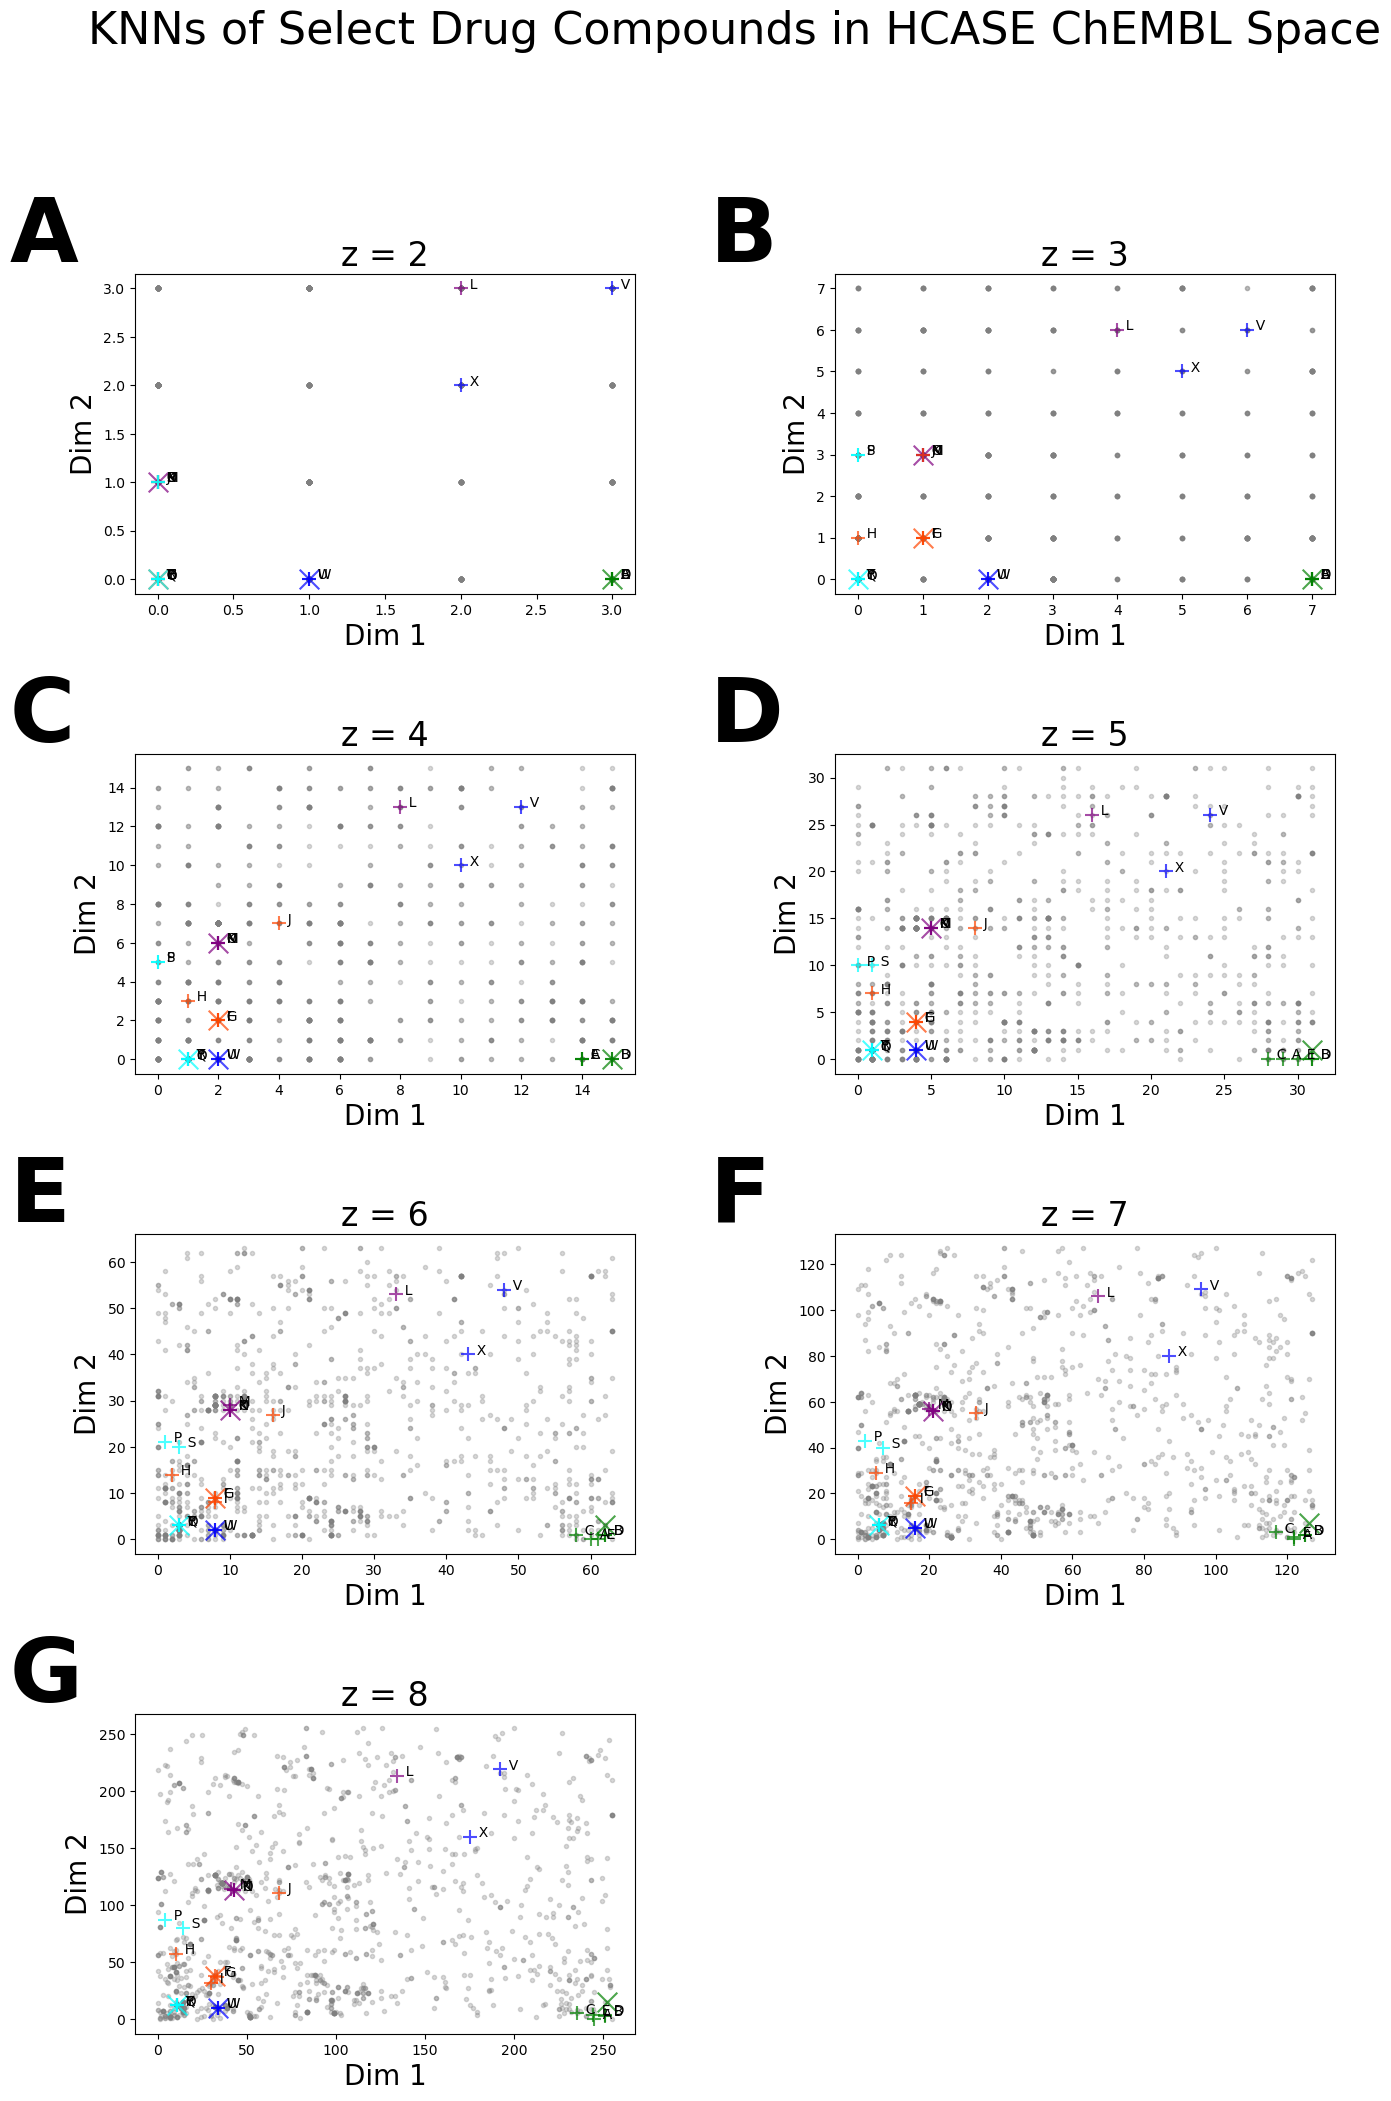

In [8]:
# Plotting KNN results

fig = plt.figure()

fig, subfigures = plt.subplots(nrows = 4, ncols = 2, figsize = (15, 22))
#fig, subfigures = plt.subplots(nrows = 4, ncols = 2, sharex = True, sharey = True, figsize = (15, 22))



panel_plot_multi (subfigures[0][0], df_2_color, df_knns, subfig_label = 'z = 2')
panel_plot_multi (subfigures[0][1], df_3_color, df_knns, subfig_label = 'z = 3')
panel_plot_multi (subfigures[1][0], df_4_color, df_knns, subfig_label = 'z = 4')
panel_plot_multi (subfigures[1][1], df_5_color, df_knns, subfig_label = 'z = 5')
panel_plot_multi (subfigures[2][0], df_6_color, df_knns, subfig_label = 'z = 6')
panel_plot_multi (subfigures[2][1], df_7_color, df_knns, subfig_label = 'z = 7')
panel_plot_multi (subfigures[3][0], df_8_color, df_knns, subfig_label = 'z = 8')


subfigures[3][1].axis('off')


subfigures[0][0].text(-0.25, 1.25, "A", transform=subfigures[0][0].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[0][1].text(-0.25, 1.25, "B", transform=subfigures[0][1].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[1][0].text(-0.25, 1.25, "C", transform=subfigures[1][0].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[1][1].text(-0.25, 1.25, "D", transform=subfigures[1][1].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[2][0].text(-0.25, 1.25, "E", transform=subfigures[2][0].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[2][1].text(-0.25, 1.25, "F", transform=subfigures[2][1].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[3][0].text(-0.25, 1.25, "G", transform=subfigures[3][0].transAxes,
            fontsize=64, fontweight='bold', va='top')

fig.suptitle('KNNs of Select Drug Compounds in HCASE ChEMBL Space', fontsize = 32, y = 1.02)
#fig.supylabel('Dim 2')


plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)

plt.savefig (fname_out_knn_drugs_emb_hcase_chembl, dpi=300)

plt.show()




In [9]:
 # Workflow for Not KNN (RND "neighbor") analysis




# Remove randomly selected 5 molecules from original (valid) set
df_valid_rnd = df_valid[~df_valid['id'].isin(df_rnd['id'])]

df_not_nn = df_valid_rnd.sample(n = num_not_nn_rnd_molecules, random_state = random_seed_not_nn)

df_rnd['key'] = 1
df_not_nn['key'] = 1

df_paired = df_rnd.merge(df_not_nn, on = 'key', how = 'inner')

df_sim = compute_sim (df_paired, 'structure_x', 'structure_y', 'id_x', 'id_y', fp_radius, fp_length)

#print (df_sim)
#df_all_knns = knn.morgan_knn (df_valid_rnd, df_valid_rnd, str1_col = 'structure', str2_col = 'structure', id1_col = 'id', id2_col = 'id', radius = 3, fplength = 2048, k = 5)

df_sim.to_csv (fname_out_drugs_not_nn_5_sim, sep = '\t', index = False)


df_rnd['not_nn_color'] = df_rnd.apply (lambda x: get_query_color (x['id'], colors), axis = 1)
df_not_nn['not_nn_color'] = 'gray'

df_not_nn = df_not_nn.reset_index (drop = True)
df_not_nn['idx'] = df_not_nn.index
df_rnd['idx'] = -1


df_not_nn['not_nn_label'] = df_not_nn.apply(lambda x: get_letter(data_labels_rnd, x['id']), axis = 1)
df_rnd['not_nn_label'] = ''

df_not_nn_final = df_rnd.append(df_not_nn, ignore_index = True)
df_not_nn_final.to_csv (fname_out_drugs_not_nn_5, sep = '\t', index = False)

query_ids = df_rnd['id'].values
not_nn_ids = df_not_nn['id'].values





<Figure size 640x480 with 0 Axes>

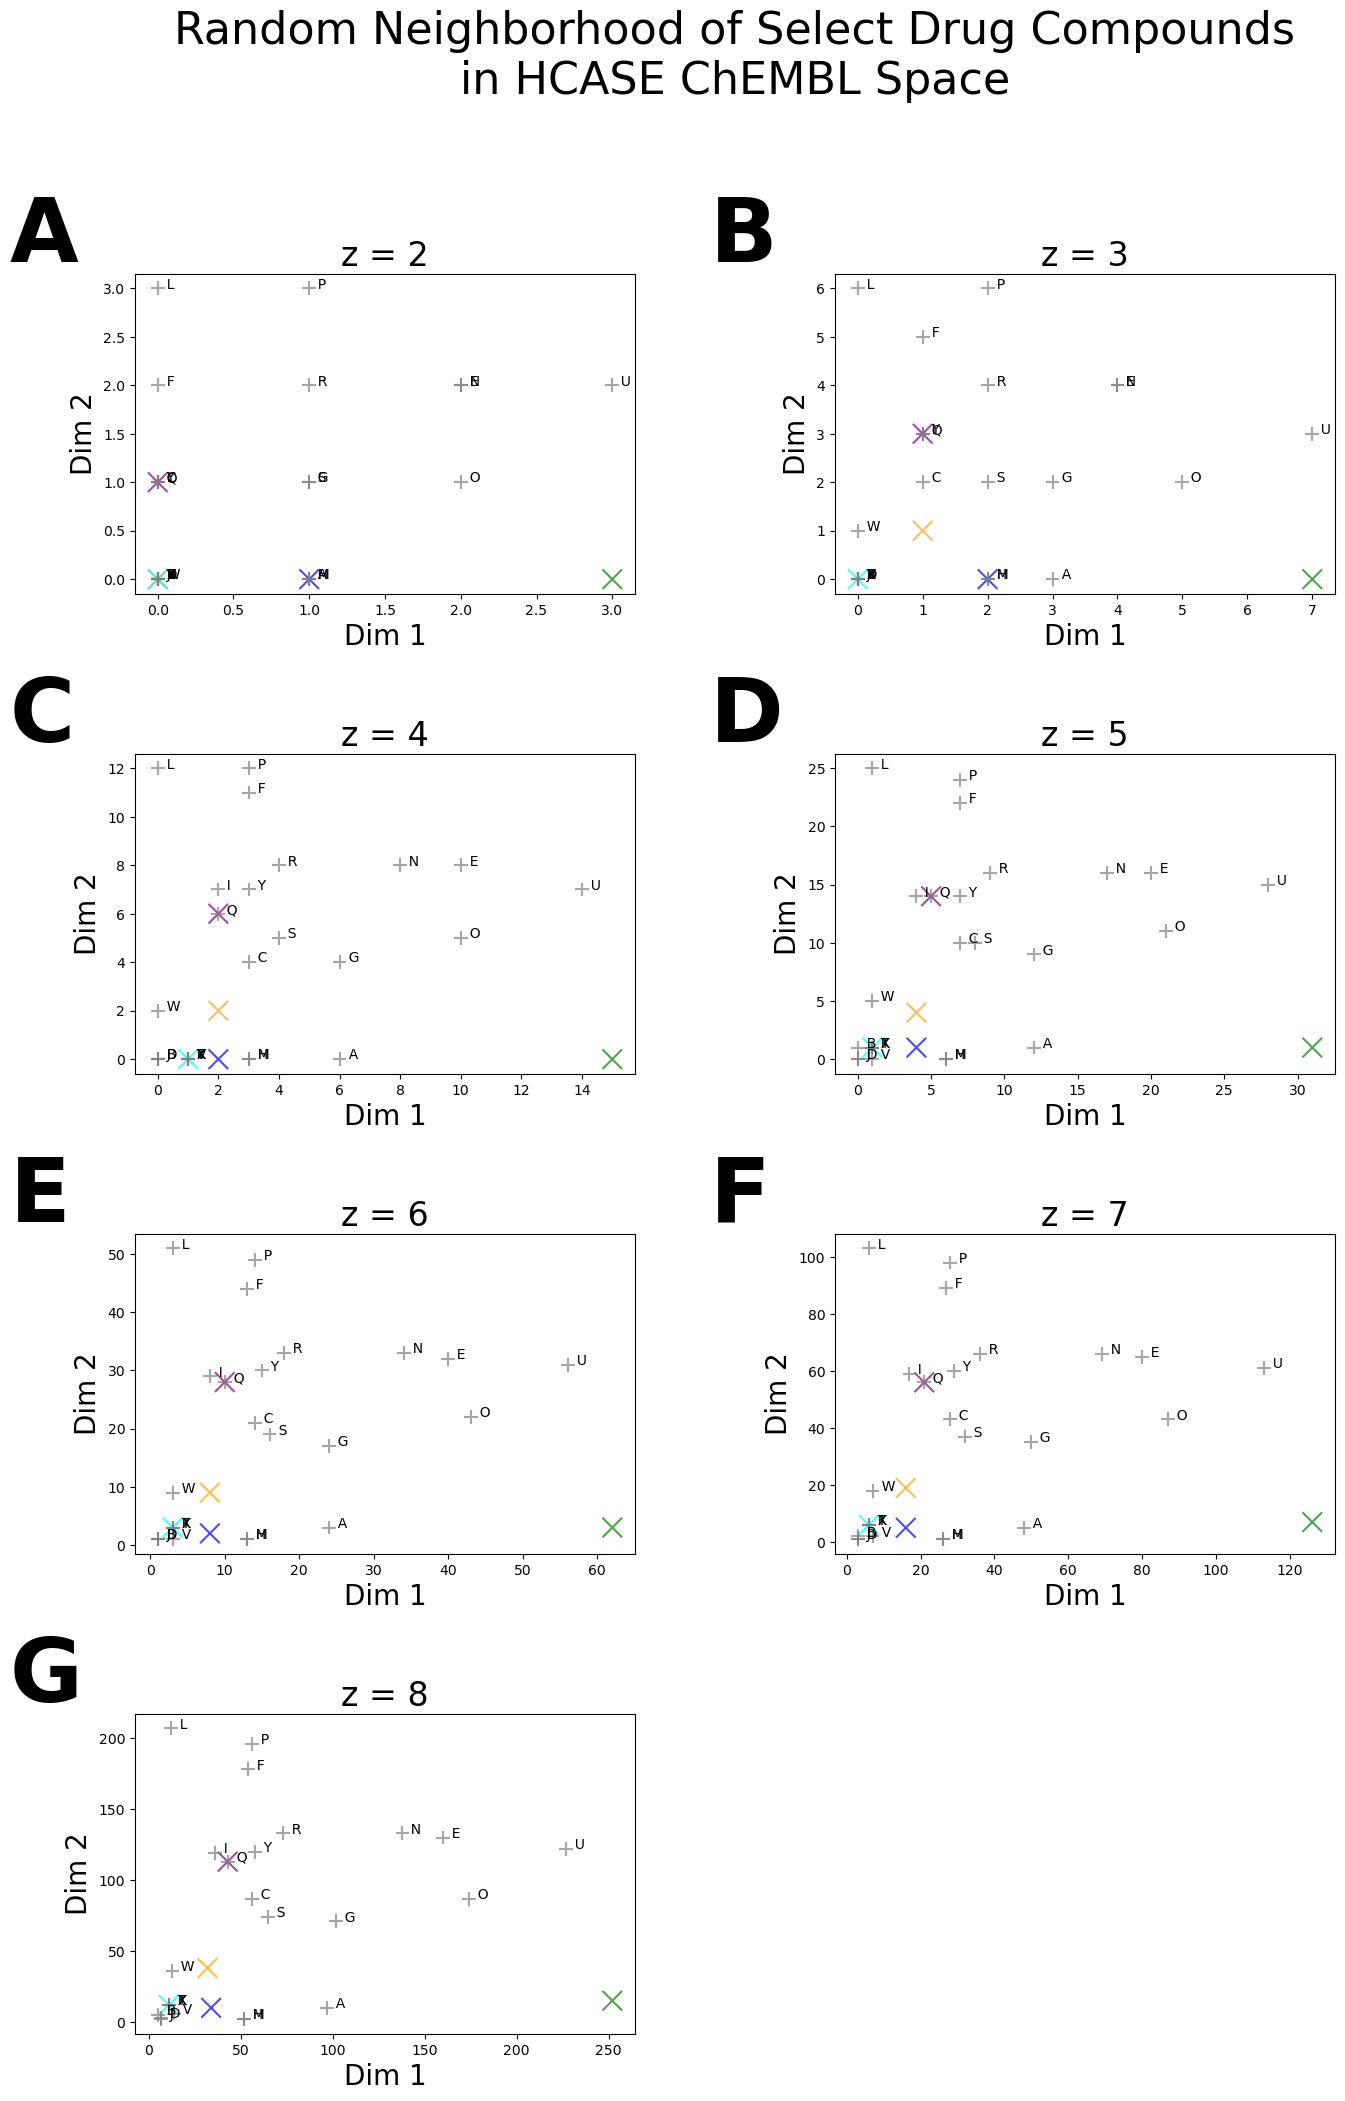

In [10]:
# Plotting Not NN results

fig = plt.figure()

fig, subfigures = plt.subplots(nrows = 4, ncols = 2, figsize = (15, 22))


make_rnd_plots (subfigures[0][0], df_2, query_ids, not_nn_ids, data_labels_rnd, subfig_label = 'z = 2')
make_rnd_plots (subfigures[0][1], df_3, query_ids, not_nn_ids, data_labels_rnd, subfig_label = 'z = 3')
make_rnd_plots (subfigures[1][0], df_4, query_ids, not_nn_ids, data_labels_rnd, subfig_label = 'z = 4')
make_rnd_plots (subfigures[1][1], df_5, query_ids, not_nn_ids, data_labels_rnd, subfig_label = 'z = 5')
make_rnd_plots (subfigures[2][0], df_6, query_ids, not_nn_ids, data_labels_rnd, subfig_label = 'z = 6')
make_rnd_plots (subfigures[2][1], df_7, query_ids, not_nn_ids, data_labels_rnd, subfig_label = 'z = 7')
make_rnd_plots (subfigures[3][0], df_8, query_ids, not_nn_ids, data_labels_rnd, subfig_label = 'z = 8')
subfigures[3][1].axis('off')

subfigures[0][0].text(-0.25, 1.25, "A", transform=subfigures[0][0].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[0][1].text(-0.25, 1.25, "B", transform=subfigures[0][1].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[1][0].text(-0.25, 1.25, "C", transform=subfigures[1][0].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[1][1].text(-0.25, 1.25, "D", transform=subfigures[1][1].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[2][0].text(-0.25, 1.25, "E", transform=subfigures[2][0].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[2][1].text(-0.25, 1.25, "F", transform=subfigures[2][1].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[3][0].text(-0.25, 1.25, "G", transform=subfigures[3][0].transAxes,
            fontsize=64, fontweight='bold', va='top')

fig.suptitle('Random Neighborhood of Select Drug Compounds\nin HCASE ChEMBL Space', fontsize = 32, y = 1.02)
#fig.supylabel('Dim 2')


plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)

plt.savefig (fname_out_not_nn_drugs_emb_hcase_chembl, dpi=300)

In [11]:
# References


# Ref: https://github.com/matplotlib/matplotlib/issues/3466/
# Ref: https://iwatobipen.wordpress.com/2017/11/03/draw-high-quality-molecular-image-in-rdkit-rdkit/
# Ref: https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html
# Ref: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# Ref: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html
# Ref: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.title.html
# Ref: https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers
# Ref: https://matplotlib.org/3.1.1/gallery/shapes_and_collections/scatter.html
# Ref: https://matplotlib.org/3.1.1/tutorials/colors/colors.html
# Ref: https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
# Ref: https://python-graph-gallery.com/106-seaborn-style-on-matplotlib-plot/
# Ref: https://python-graph-gallery.com/122-multiple-lines-chart/
# Ref: https://python-graph-gallery.com/125-small-multiples-for-line-chart/
# Ref: https://seaborn.pydata.org/examples/many_facets.html
# Ref: https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point
# Ref: https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size
# Ref: https://stackoverflow.com/questions/17682216/scatter-plot-and-color-mapping-in-python
# Ref: https://stackoverflow.com/questions/31686530/matplotlib-generate-a-new-graph-in-a-new-window-for-subsequent-program-runs/31686783
# Ref: https://stackoverflow.com/questions/39870642/matplotlib-how-to-plot-a-high-resolution-graph
# Ref: https://www.rdkit.org/docs/GettingStartedInPython.html
# Ref: https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html
# Ref: https://www.geeksforgeeks.org/how-to-create-multiple-subplots-in-matplotlib-in-python/
# Ref: https://stackoverflow.com/questions/44970881/matplotlib-multiple-scatter-subplots-with-shared-colour-bar
# Ref: https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots#:~:text=To%20change%20figure%20size%20of,10))%20when%20creating%20subplots.&text=For%20plotting%20subplots%20in%20a,numpy%20array%20(2%20dimensional).
# Ref: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_title.html
# Ref: https://stackoverflow.com/questions/65901634/matplotlib-figure-supxlabel-does-not-work
# Ref: https://www.mathworks.com/help/matlab/ref/xlabel.html
# Ref: https://stackoverflow.com/questions/6963035/how-to-set-common-axes-labels-for-subplots
# Ref: https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size
# Ref: https://stackoverflow.com/questions/10035446/how-can-i-make-a-blank-subplot-in-matplotlib
# Ref: https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
# Ref: https://stackoverflow.com/questions/16419670/increase-distance-between-title-and-plot-in-matplolib
# ChatGPT 3.5: spacing between main title and first row of subfigures.


